# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col,udf
from pyspark.sql.functions import countDistinct
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import avg as Favg
from pyspark.sql.types import IntegerType,StringType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
import datetime
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import time

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .config("spark.driver.memory", "12g")\
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'

In [4]:
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# number of rows and columns
df.count(), len(df.columns)

(286500, 18)

In [7]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [8]:
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


There aren’t any nan values in data, many null values. But what about empty values? 

In [10]:
# number of empty userID
df.filter(df['userId'] == '').count()

8346

In the next step, I look at other columns when the userId is empty 

In [11]:
df.filter(df['userId'] == '').collect()

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=101, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=8, song=None, status=200, ts=1538355807000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=102, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355841000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='free', location=None, method='PUT', page='Login', registration=None, s

At first view, it seems, that userId is empty, when the user visits Login or Home page. Let us look deeper into it

In [12]:
# type of pages
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [13]:
df.filter(df['userId'] == '').groupby('page').count().show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|Submit Registration|    5|
|              Login| 3241|
|           Register|   18|
|               Help|  272|
|              Error|    6|
+-------------------+-----+



From the table above we can see, that the userId is empty when the user isn’t login. For that reason I drop all rows with empty userIds

In [14]:
df = df.filter(df["userId"] != "")

In [15]:
df.count()

278154

Now, we should investigate whether there are any empty values in other important rows

In [16]:
def empty_colums():
    """
    Caclulate number of empty values in each column
    Input : None
    Output: None
    """
    name_of_columns = df.columns
    for name in name_of_columns:
        print(name + " " + str(df.filter(df[name] == '').count()))

In [17]:
empty_colums()

artist 0
auth 0
firstName 0
gender 0
itemInSession 0
lastName 0
length 0
level 0
location 0
method 0
page 0
registration 0
sessionId 0
song 0
status 0
ts 0
userAgent 0
userId 0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


For analysis we don’t want to count the user who cancelled as active user before cancellation. For that reason, I add column stage to distinguish active user and who churned

In [18]:
def churn(df_data):
    """
    Add new columns for churned 1 else 0
    plus highlight (stage) customer churn
    Input df_data: pyspark.sql.dataframe.DataFrame
    Output: df_data: pyspark.sql.dataframe.DataFrame 
    """
    
    # add column with 0 or 1
    churn = udf(lambda x : int((x == 'Cancellation Confirmation')), IntegerType())
    df_data = df_data.withColumn("Churned", churn("page"))
    
    # highlight user who churned
    df_data = df_data.withColumn("stage", Fsum('Churned').over(Window.partitionBy('UserId')))
    return df_data

In [19]:
df = churn(df)

In [20]:
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churned=0, stage=0)

In [21]:
df.select('UserId').filter(df["Churned"] == 1).show()

+------+
|UserId|
+------+
|    18|
|    32|
|   125|
|   105|
|    17|
|   143|
|   101|
|   129|
|   121|
|    51|
|    87|
|   122|
|    12|
|    58|
|    73|
|     3|
|   106|
|   103|
|    28|
|    54|
+------+
only showing top 20 rows



In [22]:
df.groupby('Churned').count().show()

+-------+------+
|Churned| count|
+-------+------+
|      1|    52|
|      0|278102|
+-------+------+



Ok, now we have 52 rows with cancellations.  

In [23]:
# count unique userId
df.select("userId").dropDuplicates().count()

225

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [24]:
def user_churn_visualisation(df_data, col_name, size=False):
    """
    Barplot for selected column based on churned/not churned user
    
    Input: 
        df_data: pyspark.sql.dataframe.DataFrame
        col_name: str: name of the column
    
    Ourput: None
    
    """
    df_cleaned = df_data.drop_duplicates(['userId','stage']).groupby(['stage', col_name]).count().sort(col_name).toPandas()
    if size: 
        fig, ax = plt.subplots(figsize=(20, 10))
        sns.barplot( x = col_name, y = 'count', hue='stage', data = df_cleaned, ax=ax)
        plt.xticks(rotation=90)
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.barplot( x = 'stage', y = 'count', data = df_cleaned, hue = col_name, ax=ax)
    plt.title(col_name + ' of customer and customer churn')
    plt.legend(loc='best')
    plt.show()
    
    

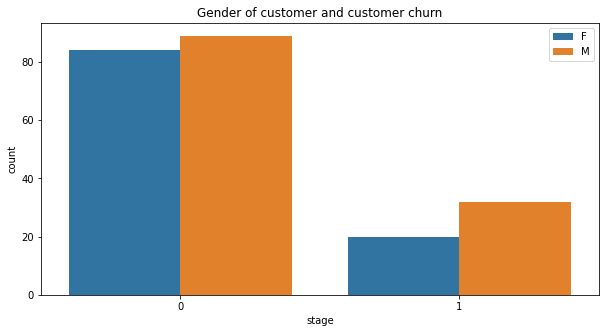

In [25]:
user_churn_visualisation(df, 'Gender')

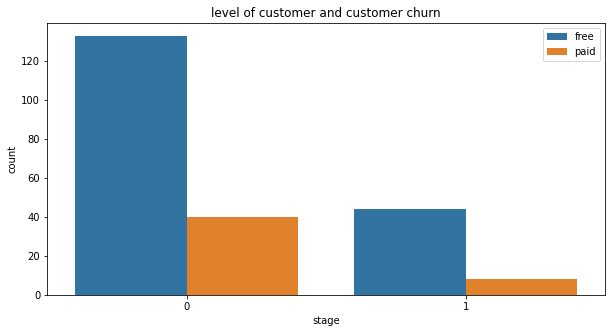

In [26]:
user_churn_visualisation(df, 'level')

The graphics above make it clear, that there is small difference between churn and not churn based on gender. In addition, most of the customer prefer listening music for free. 

In [27]:
df.select("location").dropDuplicates().sort("location").count()

114

There are 114 locations for 225 unique users. For the churn analysis on the small dataset is this division too fine-grained. Therefore, I will normalize the location from 'Bakersfield, CA' to ‘CA’.

In [28]:
def extract_state(x):
    """
    Extract state name from location 
    Input : str e.g. 'Bakersfield, CA' 
    Output: str 'CA'
    """
    
    return x.split(',')[1].lstrip()

In [29]:
def extract_city(x):
    """
    Extract city name from location 
    Input : str e.g. 'Bakersfield, CA' 
    Output: str 'Bakersfield'
    """
    city = x.split(',')[0].rstrip()
    if "-" in city:
        temp_city = city.split('-')[0].rstrip()
        return temp_city
    else:
        return city

In [30]:
get_state = udf(extract_state,  StringType())
df = df.withColumn('state', get_state(df.location) )

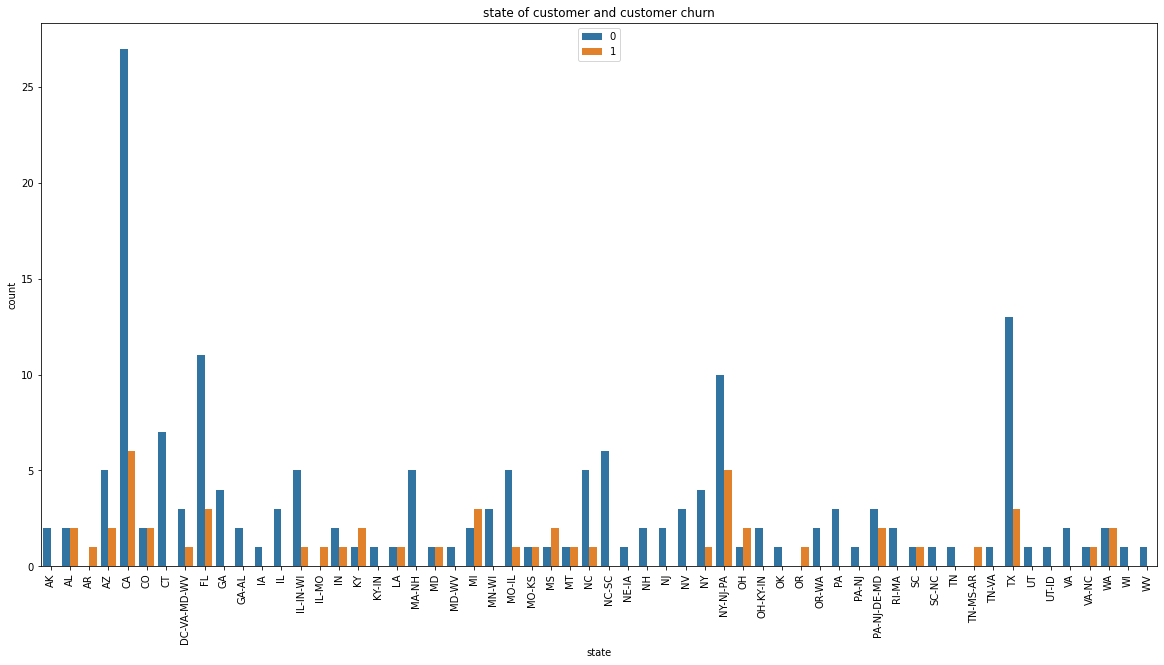

In [31]:
user_churn_visualisation(df, 'state', True)

In [32]:
get_city = udf(extract_city,  StringType())
df = df.withColumn('city', get_city(df.location) )

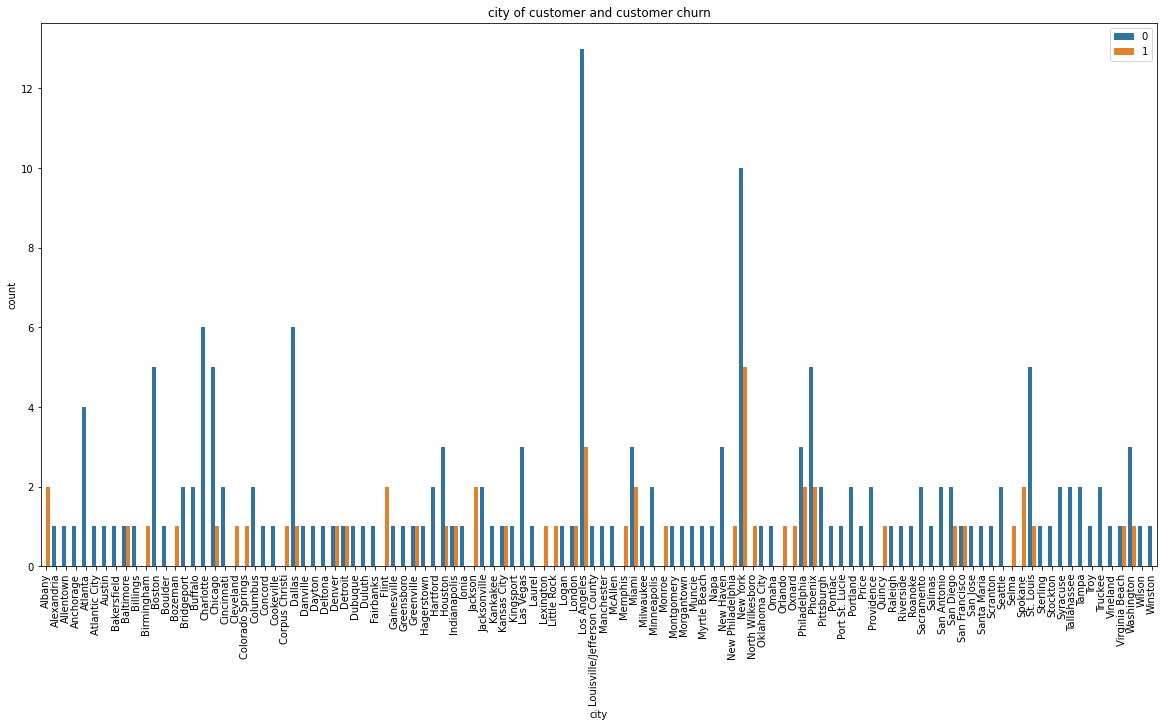

In [33]:
user_churn_visualisation(df, 'city', True)

In [34]:
df.select("state").dropDuplicates().sort("state").count()

If we look at bar chart, we can see that California, Florida and Texas have the greatest number of users. Even though, some states don’t have churned user (e.g., Nevada, Iowa or Illinois) the graphic shows clearly, that the number of user in this stages is low as well.

In the next step, I will investigate the churn rate based on device type. Does the brand or type of device influence the number of churn ? 

In [35]:
df.select("userAgent").dropDuplicates().sort("userAgent").show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



Bevor, we can start with analysis, we must extract the device type from userAgent
e.g, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"'


In [36]:
def extract_device(x):
    device_type = ['Windows', 'iPad', 'iPhone', 'Mac','Linux']
    for d in device_type:X
        if d in x:
            return d

In [37]:
get_device = udf(extract_device, StringType())
df = df.withColumn('device', get_device(df.userAgent))

In [38]:
# check whether all devices were extracted 
df.where(col("device").isNull()).collect()

[]

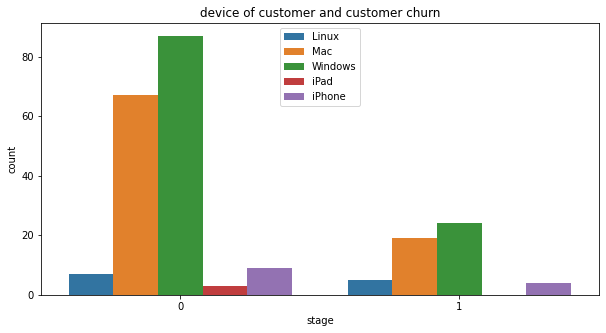

In [39]:
user_churn_visualisation(df, 'device')

Now, let us look at the number of active users, user who listened at least one song in the month. So we can determine how many user are using the offered service on regular basis

First of all, I convert the timestamp to hour, month, year, weekday

In [40]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [41]:
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). year)

In [42]:
get_weekday= udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). weekday())

In [43]:
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)

In [44]:
get_y_m_d= udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))

In [45]:
df =  df.withColumn("hour", get_hour(df.ts))

In [46]:
df = df.withColumn("year", get_year(df.ts))

In [47]:
df = df.withColumn("weekday", get_weekday(df.ts))

In [48]:
df = df.withColumn("month", get_month(df.ts))

In [49]:
df = df.withColumn("Y_m_d", get_y_m_d(df.ts))

In [50]:
#  Check how many years there are in the data set
df.select("year").dropDuplicates().sort("year").show()

+----+
|year|
+----+
|2018|
+----+



In [51]:
#  Check how many Months there are in the data set
df.select("month").dropDuplicates().sort("month").show()

+-----+
|month|
+-----+
|   10|
|   11|
|   12|
+-----+



We are dealing with only one year and from this year: three months

In [52]:
user_month_df = df.filter(df.page == "NextSong").groupby(["userId","month"]).count().toPandas()

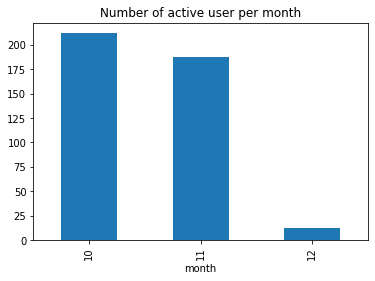

In [53]:
user_month_df[user_month_df["count"]>0].groupby("month")["userId"].count().reset_index().plot.bar(x="month", y="userId",legend=None)
plt.title("Number of active user per month");

The graphic above shows the sharp decrease of active user in December. For this reason, it is recommended that the  Business follow up to analyse the reason of sharp drop. Question should be: is this issue due to the small dataset or due to the service?  

In [54]:
del user_month_df

In [55]:
user_day_df= df.filter(df.page == "NextSong").groupby(["userId","weekday"]).count().toPandas()

In [56]:
user_day_count = user_day_df[user_day_df["count"]>0].groupby("weekday")["userId"].count().reset_index()

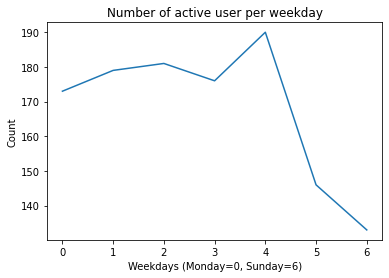

In [57]:
sns.lineplot(data=user_day_count, x="weekday", y="userId")
plt.xlabel("Weekdays (Monday=0, Sunday=6)")
plt.ylabel("Count")
plt.title("Number of active user per weekday");

The graphic makes it clear that there are approximately same amount (constant) of user from Monday to Thursday with strong increase on Friday and the drop on Saturday/ Sunday  

### Unique Artists

Ok, now we know how many active users we have and when do they preferer to listen to the music. However, the question is still remains: how long do they use the service and how many songs do they listen to? Do we have enough artists in our offer? 

In [58]:
df.select("artist").dropDuplicates().count()

17656

In [59]:
df.select("song").dropDuplicates().count()

58481

In [60]:
def user_churn_bloxplot(df_data, col_name):
    """
    Boxplot for selected column based on churned/not churned user
    
    Input: 
        df_data: pyspark.sql.dataframe.DataFrame
        col_name: str: name of the column
    
    Ourput: None
    
    """
    
    df_cleaned = df_data.drop_duplicates(['userId','stage']).groupby(['stage', col_name]).count().sort(col_name).toPandas()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(y=col_name, x="stage", data=df_cleaned)
    plt.title(col_name + ' of customer and customer churn')
    plt.show()
   
    

In [61]:
user_artists_cnt = df.select('userId', 'artist').groupby('userId').agg(countDistinct("artist")).withColumnRenamed('count(artist)', 'total_cnt_artists')

In [62]:
df = df.join(user_artists_cnt, on='userId')

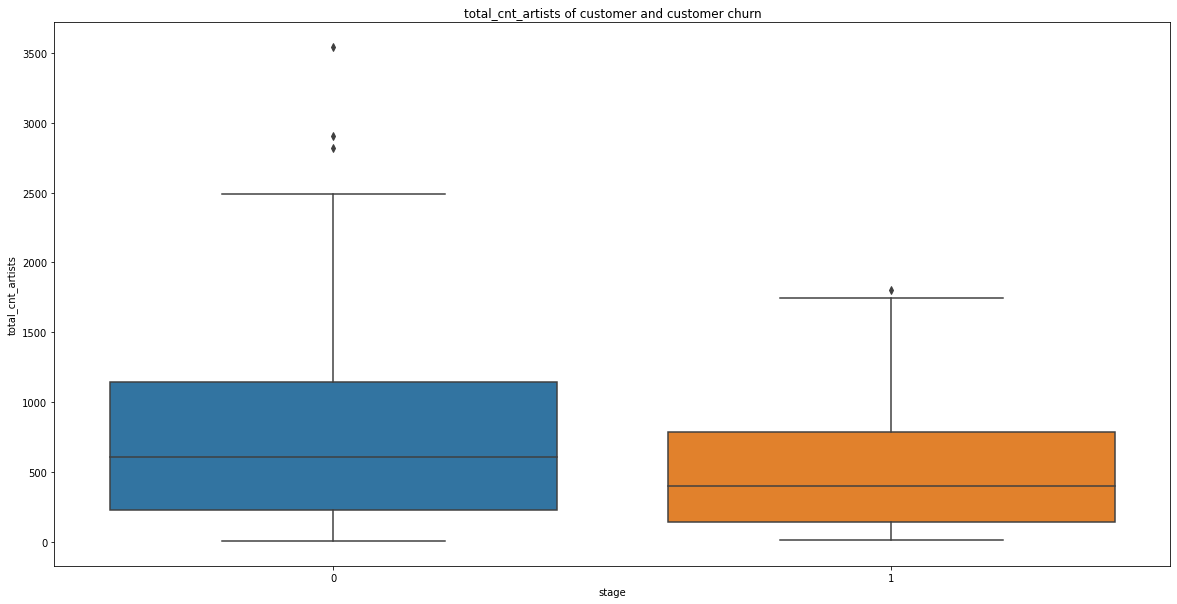

In [63]:
user_churn_bloxplot(df,'total_cnt_artists' )

### User Session Max value

In [64]:
user_max_items_session = df.select('userId', 'itemInSession', 'sessionId').groupby(['userId'])\
                .agg(Fmax("itemInSession")).withColumnRenamed('max(itemInSession)', 'max_items_session')

In [65]:
df = df.join(user_max_items_session, on='userId')

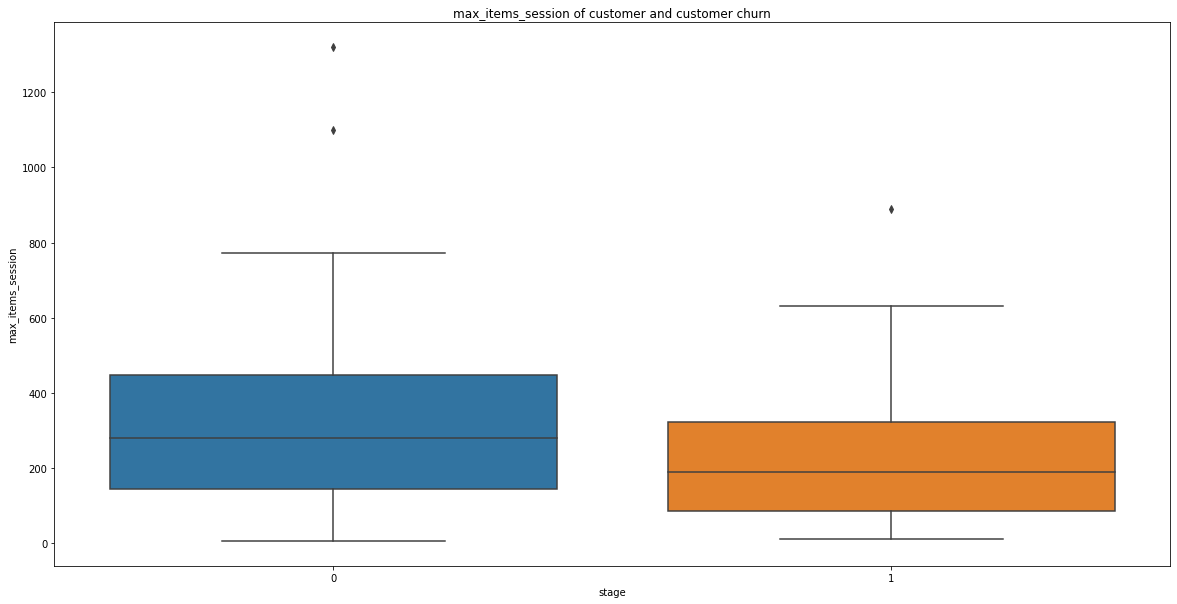

In [66]:
user_churn_bloxplot(df,'max_items_session' )

### User Session Min value

In [67]:
user_min_items_session = df.select('userId', 'itemInSession', 'sessionId').groupby(['userId'])\
                .agg(Fmin("itemInSession")).withColumnRenamed('min(itemInSession)', 'min_items_session')

In [68]:
df = df.join(user_min_items_session, on='userId')

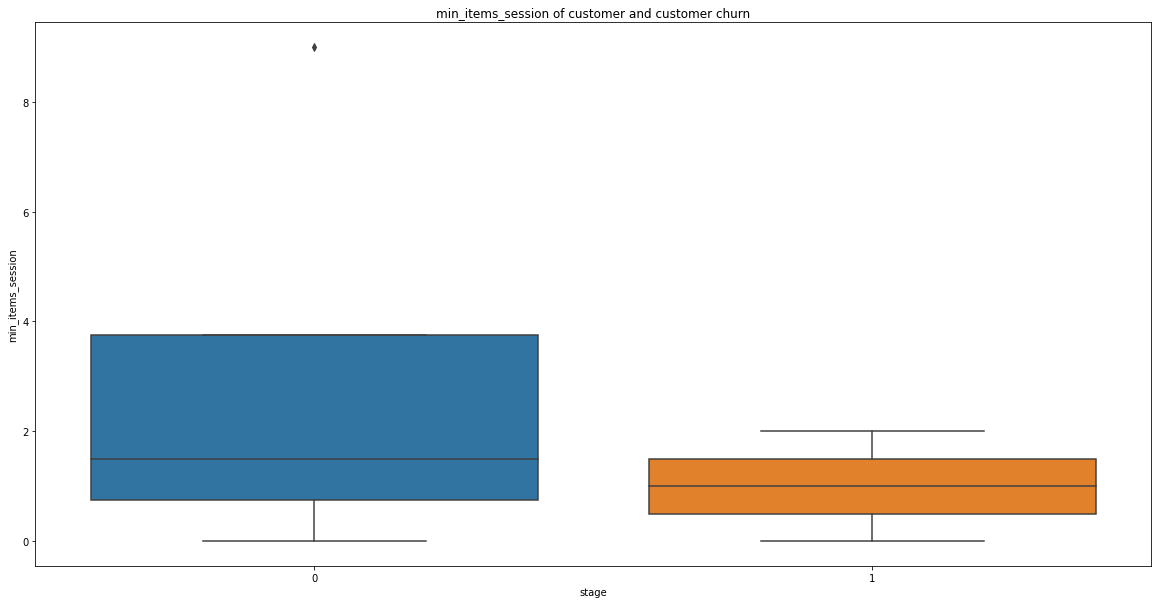

In [69]:
user_churn_bloxplot(df,'min_items_session' )

### User Session Avg value

In [70]:
user_avg_items_session = df.select('userId', 'itemInSession', 'sessionId').groupby(['userId'])\
                .agg(Favg("itemInSession")).withColumnRenamed('avg(itemInSession)', 'avg_items_session')

In [71]:
df = df.join(user_avg_items_session, on='userId')

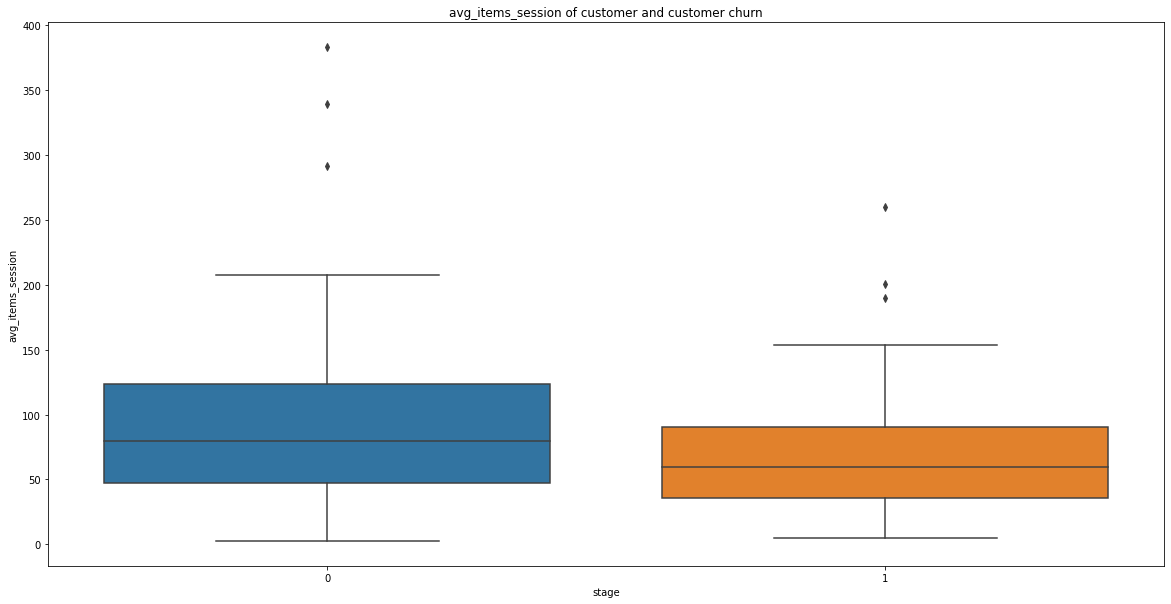

In [72]:
user_churn_bloxplot(df,'avg_items_session' )

### User Session Mode value

In [73]:
cnt_user_items = df.groupby('userId', 'itemInSession').count().orderBy("count", ascending=False).withColumnRenamed('itemInSession', 'mode_items_session')

In [74]:
cnt_user_items = cnt_user_items.drop('count')

In [75]:
mode_cnt_user_items = cnt_user_items.dropDuplicates(subset = ['userId'])

In [76]:
df = df.join(mode_cnt_user_items, on='userId')

In [77]:
# df.filter(df["UserId"] == 39).collect()

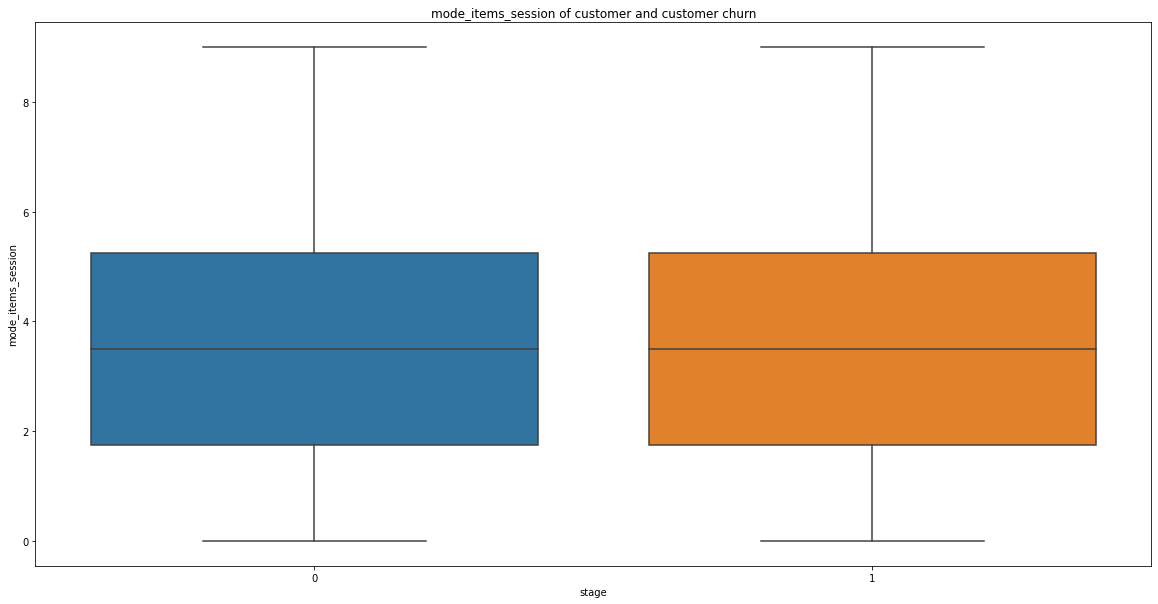

In [78]:
user_churn_bloxplot(df,'mode_items_session' )

## Page Avg Error

In [79]:
def avg_pages(df_data, page_name,new_column_name):
    """
    Add column average for specific page
    
    Input:
        df_data: pyspark.sql.dataframe.DataFrame
        page_name: str: page name
        new_column_name: str: name of new column
    Output:
        df_data: pyspark.sql.dataframe.DataFrame
                with new column  
    """
    user_cnt = df_data.select('userId',"page","Y_m_d").filter(df_data.page == page_name).\
        groupby(["userId","Y_m_d","page"]).count().\
        groupby(["userId"]).agg(Favg("count")).withColumnRenamed('avg(count)', new_column_name)
    df_data = df_data.join(user_cnt,how = "left", on='userId')
    return df_data

In [80]:
df = avg_pages(df, "Error", 'avg_error')

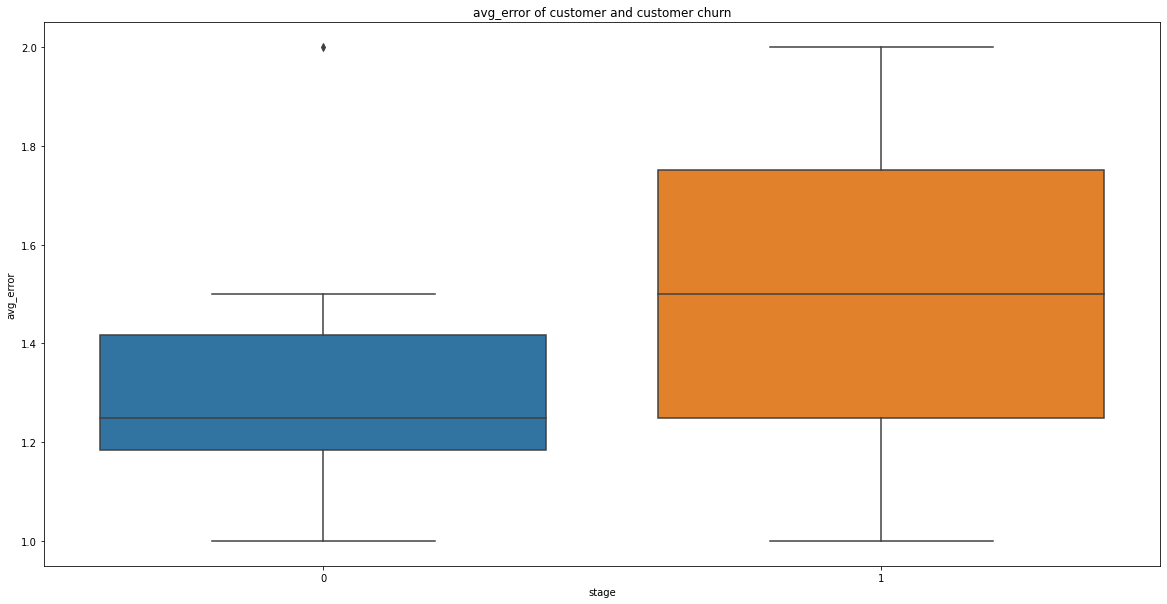

In [81]:
user_churn_bloxplot(df,'avg_error')

### Avg Advert

In [82]:
df = avg_pages(df, 'Roll Advert', 'avg_advert')

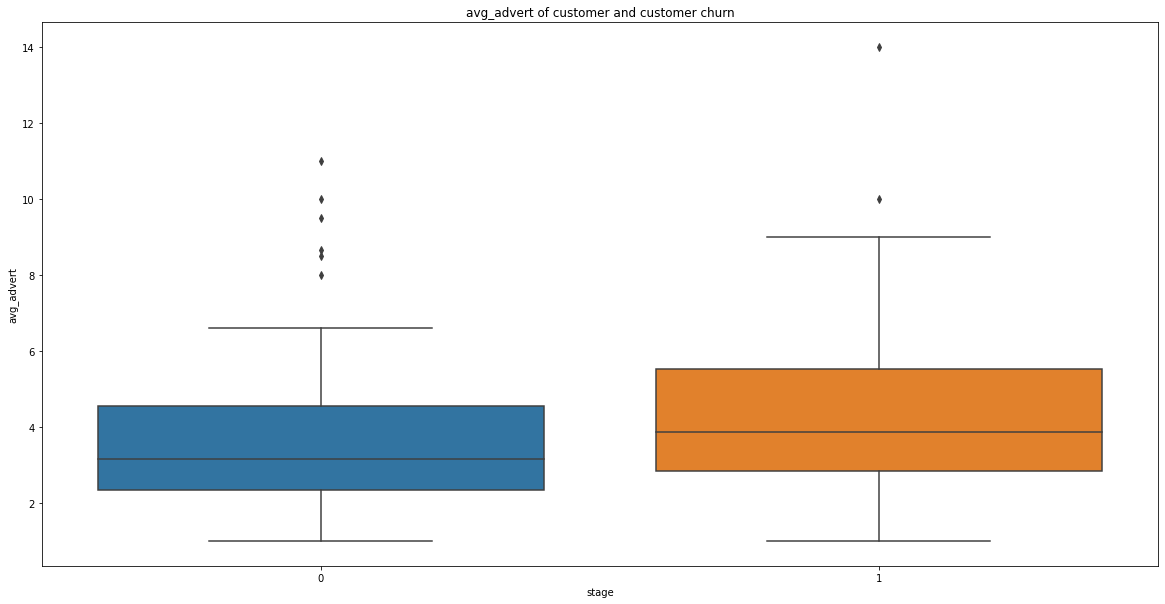

In [83]:
user_churn_bloxplot(df,'avg_advert')

### Avg Thumbs Up

In [84]:
df = avg_pages(df, 'Thumbs Up', 'avg_thumbs_up')

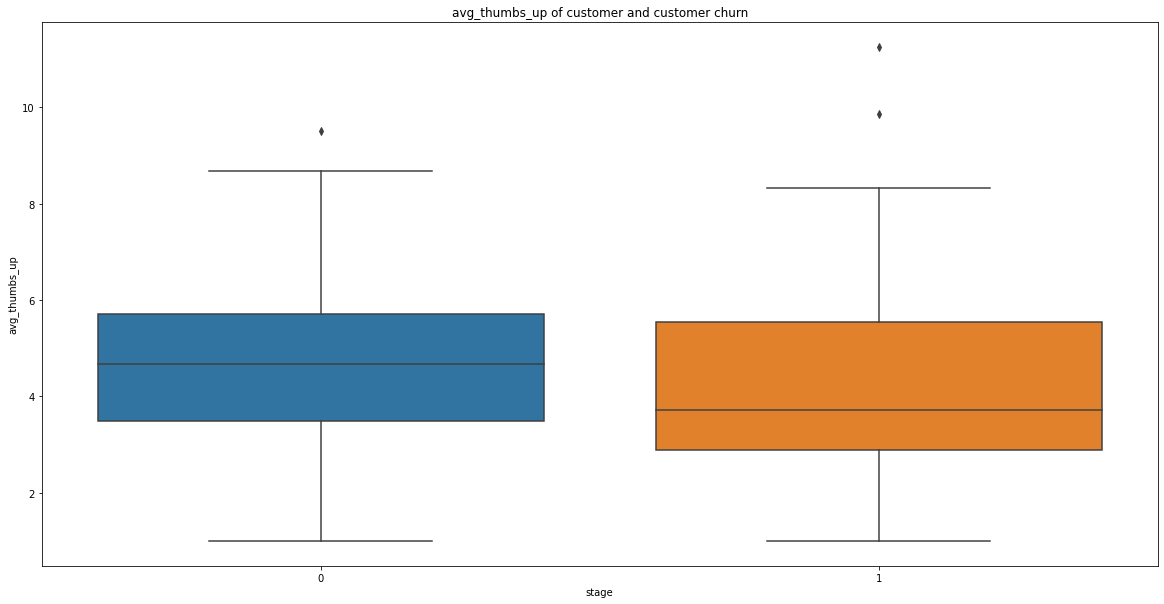

In [85]:
user_churn_bloxplot(df,'avg_thumbs_up')

### Avg Thumbs Down

In [86]:
df = avg_pages(df, 'Thumbs Down', 'avg_thumbs_down')

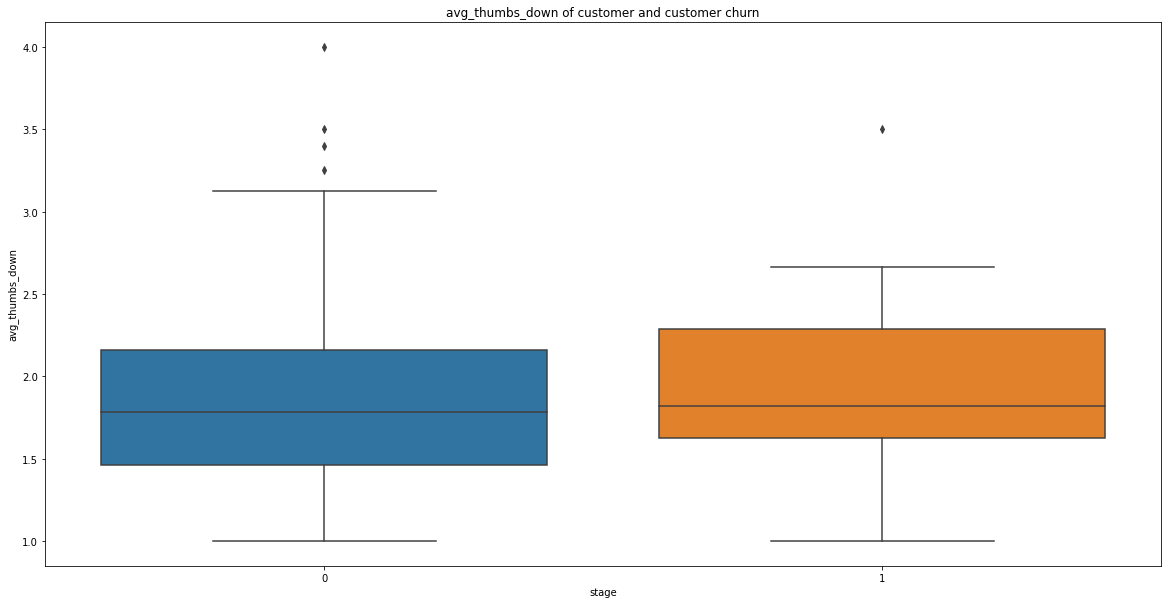

In [87]:
user_churn_bloxplot(df,'avg_thumbs_down')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Due to the constrain with imbalanced dataset extra feature will be integrated into the model in order to weight classes "classWeightCol"

Due to the dataset analysis the needed features have been already implemented. The mode_items_session will be excluded from features due to no big difference between two groups  

In [88]:
def balance_dataset(df_data):
    """
    https://stackoverflow.com/questions/33372838/dealing-with-unbalanced-datasets-in-spark-mllib
    Input df_data: pyspark.sql.dataframe.DataFrame
    Output: df_data: pyspark.sql.dataframe.DataFrame 
    """
    num_churn = df_data.filter(df_data["stage" ] == 1).count()
    dataset_size = df_data.count()
    balancing_ratio = (dataset_size - num_churn) / dataset_size
    calculate_weights = udf(lambda y: balancing_ratio if y ==1 else (1.0 - balancing_ratio), DoubleType())
    df_data = df_data.withColumn("classWeightCol", calculate_weights("stage"))
    return df_data 

In [89]:
user_df= df.dropDuplicates(['userId'])

In [90]:
user_df.persist()

DataFrame[userId: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, Churned: int, stage: bigint, state: string, city: string, device: string, year: string, weekday: string, month: string, Y_m_d: string, total_cnt_artists: bigint, max_items_session: bigint, min_items_session: bigint, avg_items_session: double, mode_items_session: bigint, avg_error: double, avg_advert: double, avg_thumbs_up: double, avg_thumbs_down: double]

In [91]:
user_df = user_df.fillna( { 'avg_error':0, 'avg_advert':0, 'avg_thumbs_up':0,'avg_thumbs_down':0} )

In [92]:
user_df.groupby('stage').count().show()

+-----+-----+
|stage|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [93]:
# balance sampling 
user_df = balance_dataset(user_df)

In [94]:
del df

In [95]:
def transform_data(df_data):
    """  
    Transformation of numerical and categorical data
    into feature vectors 
    
    Input: 
        df_data: pyspark.sql.dataframe.DataFrame
    
    Output: pyspark.sql.dataframe.DataFrame (label, features, classWeightCol)
            
    """
    
    
    # categorical data
    categorical_data = ["level", "device"]
    categorical_features = [StringIndexer(inputCol=c, outputCol="{0}Index".format(c))for c in categorical_data]
    stages = categorical_features
    
    
    # numerical data
    num_features = VectorAssembler(inputCols=["total_cnt_artists", "max_items_session", "min_items_session", \
                                              "avg_items_session", "avg_error",\
                                             "avg_advert","avg_thumbs_up","avg_thumbs_down"], outputCol="NumFeatures")
    
    stages.append(num_features)
    
    # feature scaler
    scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
    stages.append(scaler)

    
    # categorical and numerical features
    combined_features = VectorAssembler(inputCols=['ScaledNumFeatures','levelIndex','deviceIndex'], outputCol='features')
    stages.append(combined_features)


    
    pipeline = Pipeline().setStages(stages)
    
    
    model_features = pipeline.fit(df_data).transform(df_data)
    
    # features and label
    model_features = model_features.select('stage','features','classWeightCol').withColumnRenamed('stage', 'label')
    return model_features
    

In [96]:
user_model_vectors = transform_data(user_df)

In [97]:
user_model_vectors.head(2)

[Row(label=0, features=DenseVector([0.4173, 0.5379, 0.0, 0.6178, 0.0, 3.9815, 1.4588, 1.6221, 0.0, 2.0]), classWeightCol=0.23111111111111116),
 Row(label=0, features=DenseVector([0.5613, 0.7609, 0.0, 1.0427, 0.0, 0.804, 1.3515, 3.893, 0.0, 2.0]), classWeightCol=0.23111111111111116)]

In [98]:
del user_df

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [99]:
train, validation, test = user_model_vectors.randomSplit([0.7, 0.15, 0.15], seed=42)

In [100]:
train.persist()
validation.persist()
test.persist()

DataFrame[label: bigint, features: vector, classWeightCol: double]

In [101]:
evaluator = MulticlassClassificationEvaluator()
binary_evaluator = BinaryClassificationEvaluator()

In [154]:
def get_predictions(model, data_set):
    """
    Get predictions 
    Input:
        model: trained ML model
        data_set: sql.dataframe: with features and labels
    Output:
        return True positive/negative, False positive/negative
    """
    
    # transform dataset into trained model
    results = model.transform(data_set)
    tp = results[(results.label == 1) & (results.prediction == 1)].count()
    fp = results[(results.label == 0) & (results.prediction == 1)].count()
    fn = results[(results.label == 1) & (results.prediction == 0)].count()
    tn = results[(results.label== 0) & (results.prediction == 0)].count()
    
   
    return tp, fp, fn, tn

In [228]:
def create_confusion_matrix(tp, fp, fn, tn, model_name):
    """
    Input:
        tp: int true positives
        fp: int false positives
        fn: int false negatives 
        tn: int true negatives
        model_name: str: name of the model
    
    Output:
        None 
        
    """
    
    matrix = np.array([[tn, fp],[fn, tp]])
    n = matrix.shape[0]
    cm_df = pd.DataFrame(matrix, range(n), range(n))
    sns.heatmap(cm_df, annot=True, cmap="YlGnBu", fmt='g',annot_kws={"size": 16}) 
    plt.title('Confusion Matrix '+ model_name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [104]:
def spark_metrics(model, dataset):
    """
    Get Spark Metrics 
    Input:
        model: trained ML model
        data_set: sql.dataframe: with features and labels
    Output:
        return metrics
    """
    results = model.transform(dataset)
    f1_score = evaluator.evaluate(results,{evaluator.metricName: "f1"})
    auc = binary_evaluator.evaluate(results,{evaluator.metricName: "areaUnderROC"})
    accuracy = evaluator.evaluate(results,{evaluator.metricName: "accuracy"})
    
    return round(f1_score,2), round(auc,2), round(accuracy,2)


In [105]:
def get_all_metrics(model, data_set, model_name):
    """
    Get Sklearn Metrics and Visualisations
    Input:
        model: trained ML model
        data_set: sql.dataframe: with features and labels
        model_name: str: name of the model
    Output:
        return None
    """
    tp, fp, fn, tn = get_predictions(model, data_set)
    
    
    create_confusion_matrix(tp, fp, fn, tn, model_name)

    
    

In [321]:
def get_best_threshold(model):
    """
    https://spark.apache.org/docs/latest/ml-classification-regression.html
    Get best Threshold for prediction
    Input:
        model: pyspark ml model
    Output:
        model: pyspark ml model with new threshold
    """
    trainingSummary = model.stages[-1].summary

    # Set the model threshold to maximize F-Measure
    fMeasure = trainingSummary.fMeasureByThreshold
    maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
    bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
        .select('threshold').head()['threshold']
    model.stages[-1].setThreshold(bestThreshold)
    print("Best Threshold", bestThreshold)
    return model

### LogisticRegression

In [106]:
lr =  LogisticRegression(weightCol="classWeightCol")
pipeline_lr = Pipeline(stages=[lr])
start = time.time()
lr_model = pipeline_lr.fit(train)
end = time.time()
print("LogisticRegression Time", end - start)

LogisticRegression Time 309.5830919742584


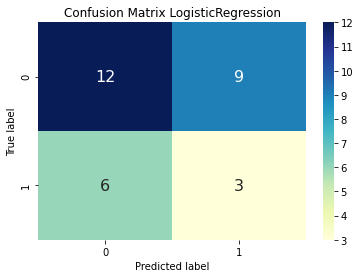

In [107]:
get_all_metrics(lr_model, test, "LogisticRegression")

In [108]:
f1_lr, auc_lr, accuracy_lr = spark_metrics(lr_model, test)

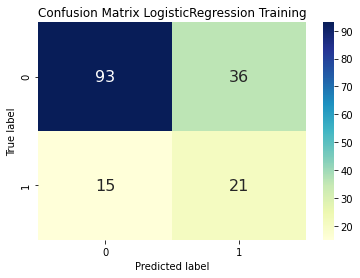

In [227]:
get_all_metrics(lr_model, train, "LogisticRegression Training")

### LogisticRegression plus Threshold

Best Threshold 0.3815966117068659


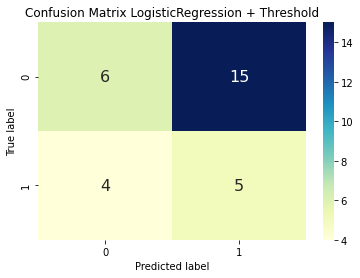

In [322]:
lr_model_threshold = get_best_threshold(lr_model)
get_all_metrics(lr_model_threshold, test, "LogisticRegression + Threshold")

In [323]:
f1_lr_threshold, auc_lr_threshold, accuracy_lr_threshold = spark_metrics(lr_model_threshold, test)

### RandomForest

In [109]:
rf = RandomForestClassifier(weightCol="classWeightCol")
pipeline_rf = Pipeline(stages=[rf])
start = time.time()
rf_model = pipeline_rf.fit(train)
end = time.time()
print("RandomForest Time", end - start)

RandomForest Time 78.56228303909302


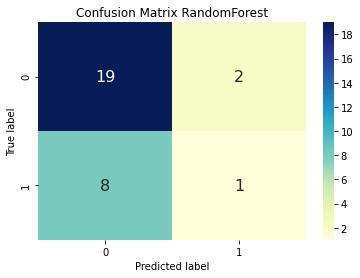

In [110]:
get_all_metrics(rf_model, test, "RandomForest")

In [111]:
f1_rf, auc_rf, accuracy_rf = spark_metrics(rf_model, test)

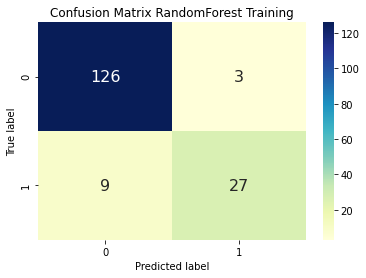

In [324]:
get_all_metrics(rf_model,train,  "RandomForest Training")

### LinearSVC

In [126]:
svm = LinearSVC(weightCol="classWeightCol")
pipeline_svm = Pipeline(stages=[svm])
start = time.time()
svm_model = pipeline_svm.fit(train)
end = time.time()
print("LinearSVC Time", end - start)

LinearSVC Time 3257.317687034607


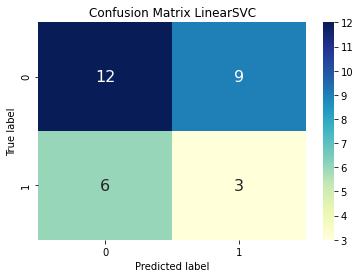

In [127]:
get_all_metrics(svm_model, test, "LinearSVC")

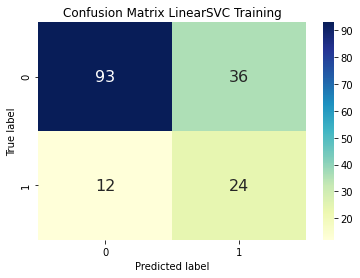

In [201]:
get_all_metrics(svm_model, train, "LinearSVC Training")

In [128]:
f1_svm, auc_svm, accuracy_svm = spark_metrics(svm_model, test)

### Gradient-boosted Tree Classifier

In [129]:
gbt = GBTClassifier(weightCol="classWeightCol")
pipeline_gbt = Pipeline(stages=[gbt])
start = time.time()
gbt_model = pipeline_gbt.fit(train)
end = time.time()
print("Gradient-boosted Classifier Time", end - start)

Gradient-boosted Classifier Time 852.3052201271057


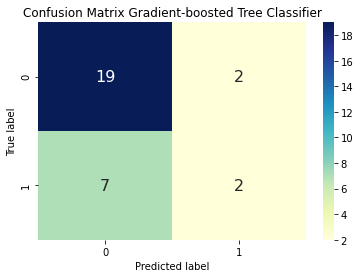

In [198]:
get_all_metrics(gbt_model, test, "Gradient-boosted Tree Classifier")
f1_gbt, auc_gbt, accuracy_gbt = spark_metrics(gbt_model, test)

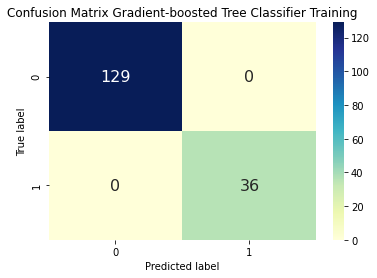

In [229]:
get_all_metrics(gbt_model, train, "Gradient-boosted Tree Classifier Training")

## Results

In [326]:
table = PrettyTable() 

In [327]:
table.field_names = ["Model", "f1_score", "Area Under ROC", "accuracy"]
table.add_row(["LogisticRegression", f1_lr, auc_lr, accuracy_lr])
table.add_row(["LogisticRegression + Threshold", f1_lr_threshold, auc_lr_threshold, accuracy_lr_threshold])
table.add_row(["LinearSVC", f1_svm, auc_svm, accuracy_svm])
table.add_row(["RandomForest", f1_rf, auc_rf, accuracy_rf])
table.add_row(["Gradient-boosted Tree ", f1_gbt, auc_gbt, accuracy_gbt])

In [328]:
print(table)

+--------------------------------+----------+----------------+----------+
|             Model              | f1_score | Area Under ROC | accuracy |
+--------------------------------+----------+----------------+----------+
|       LogisticRegression       |   0.52   |      0.43      |   0.5    |
| LogisticRegression + Threshold |   0.37   |      0.43      |   0.37   |
|           LinearSVC            |   0.52   |      0.39      |   0.5    |
|          RandomForest          |   0.6    |      0.59      |   0.67   |
|     Gradient-boosted Tree      |   0.66   |      0.51      |   0.7    |
+--------------------------------+----------+----------------+----------+


## Model Tuning

In [330]:
def create_table(f1, auc, acc, model_name, data_name):
    """
    Create pretty Output 
    
    Input:
        f1:int f1 score
        auc: int auc score
        acc: int accuracy 
        model_name: str: model name
        data_name: str: "test"/"validation"
    Output: None
    """
    print(data_name)
    t = PrettyTable()
    t.field_names = ["Model", "f1_score", "Area Under ROC", "accuracy"]
    t.add_row([model_name, f1, auc, acc])
    print(t)
    

### Parameter Tuning LogisticRegression

In [184]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.maxIter,[10,50, 100]) \
    .addGrid(lr.regParam,[0.0, 0.01, 0.05, 0.1]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.01, 0.05, 0.1]) \
    .build()


crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [185]:
prediction_lr = crossval_lr.fit(train)

In [186]:
# https://stackoverflow.com/questions/52498970/how-to-get-the-best-hyperparameter-value-after-crossvalidation-in-pyspark
print(prediction_lr.getEstimatorParamMaps()[np.argmax(prediction_lr.avgMetrics)])

{Param(parent='LogisticRegression_6cf6a4afae22', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LogisticRegression_6cf6a4afae22', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_6cf6a4afae22', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}


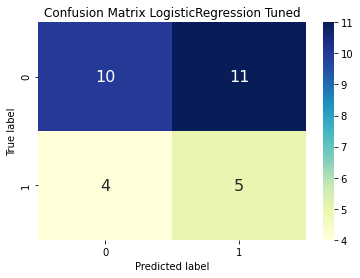

In [331]:
get_all_metrics(prediction_lr, test, "LogisticRegression Tuned")
f1_lr_best, auc_lr_best, acc_lr_best = spark_metrics(prediction_lr, test)

In [332]:
create_table(f1_lr_best, auc_lr_best, acc_lr_best, "LogisticRegression Tuned", "Test")

Test
+--------------------------+----------+----------------+----------+
|          Model           | f1_score | Area Under ROC | accuracy |
+--------------------------+----------+----------------+----------+
| LogisticRegression Tuned |   0.52   |      0.46      |   0.5    |
+--------------------------+----------+----------------+----------+


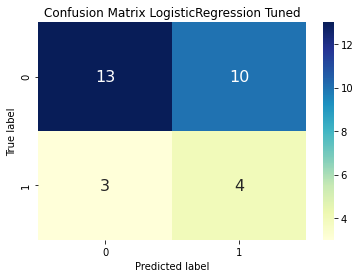

In [333]:
get_all_metrics(prediction_lr, validation, "LogisticRegression Tuned")
f1_lr_best_val, auc_lr_best_val, acc_lr_best_val = spark_metrics(prediction_lr, validation)

In [334]:
create_table(f1_lr_best_val, auc_lr_best_val, acc_lr_best_val, "LogisticRegression Tuned", "Validation")

Validation
+--------------------------+----------+----------------+----------+
|          Model           | f1_score | Area Under ROC | accuracy |
+--------------------------+----------+----------------+----------+
| LogisticRegression Tuned |   0.6    |      0.53      |   0.57   |
+--------------------------+----------+----------------+----------+


### Parameter Tuning RandomForest

In [346]:
paramGrid_rf = (
        ParamGridBuilder()
        .addGrid(rf.numTrees, [8, 10,12 ])
        .addGrid(rf.maxDepth, [8, 10,12  ])
        .addGrid(rf.impurity, ["gini", "entropy"])
        .build()
    )

prediction_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)
prediction_rf = crossval_model_rf.fit(train)

In [347]:
print(prediction_rf.getEstimatorParamMaps()[np.argmax(prediction_rf.avgMetrics)])

{Param(parent='RandomForestClassifier_a77a6bc6c155', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_a77a6bc6c155', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 8, Param(parent='RandomForestClassifier_a77a6bc6c155', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}


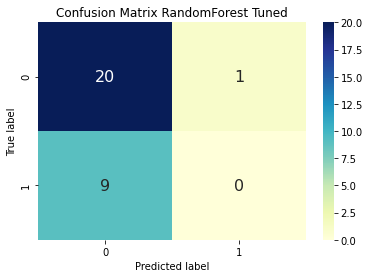

In [348]:
get_all_metrics(prediction_rf, test, "RandomForest Tuned")
f1_rf_best, auc_rf_best, acc_rf_best = spark_metrics(prediction_rf, test)

In [349]:
create_table(f1_rf_best, auc_rf_best, acc_rf_best, "RandomForest Tuned", "Test")

Test
+--------------------+----------+----------------+----------+
|       Model        | f1_score | Area Under ROC | accuracy |
+--------------------+----------+----------------+----------+
| RandomForest Tuned |   0.56   |      0.5       |   0.67   |
+--------------------+----------+----------------+----------+


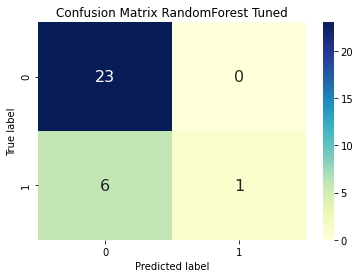

In [350]:
get_all_metrics(prediction_rf, validation, "RandomForest Tuned")
f1_rf_best_val, auc_rf_best_val, acc_rf_best_val = spark_metrics(prediction_rf, validation)

In [351]:
create_table(f1_rf_best_val, auc_rf_best_val, acc_rf_best_val , "RandomForest Tuned", "Validation")

Validation
+--------------------+----------+----------------+----------+
|       Model        | f1_score | Area Under ROC | accuracy |
+--------------------+----------+----------------+----------+
| RandomForest Tuned |   0.74   |      0.52      |   0.8    |
+--------------------+----------+----------------+----------+


### Parameter Tuning Gradient-boosted Tree Classifier

In [210]:
paramGrid_gbt = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [6, 10, 14])
             .addGrid(gbt.maxIter, [50, 60,100])
             .build())

In [211]:
crossval_model_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)
predicition_gbt= crossval_model_gbt.fit(train)

In [212]:
print(predicition_gbt.getEstimatorParamMaps()[np.argmax(predicition_gbt.avgMetrics)])

{Param(parent='GBTClassifier_9232e541e1ed', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6, Param(parent='GBTClassifier_9232e541e1ed', name='maxIter', doc='max number of iterations (>= 0).'): 50}


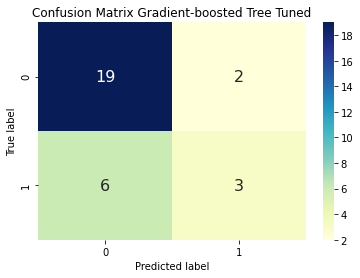

In [339]:
get_all_metrics(predicition_gbt, test, "Gradient-boosted Tree Tuned")
f1_gbt_best, auc_gbt_best, acc_gbt_best = spark_metrics(predicition_gbt, test)

In [340]:
create_table(f1_gbt_best, auc_gbt_best, acc_gbt_best, "Gradient-boosted Tree Tuned", "Test")

Test
+-----------------------------+----------+----------------+----------+
|            Model            | f1_score | Area Under ROC | accuracy |
+-----------------------------+----------+----------------+----------+
| Gradient-boosted Tree Tuned |   0.71   |      0.48      |   0.73   |
+-----------------------------+----------+----------------+----------+


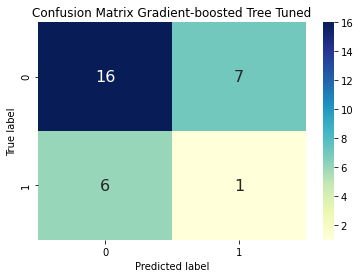

In [341]:
get_all_metrics(predicition_gbt, validation, "Gradient-boosted Tree Tuned")
f1_gbt_best_val, auc_gbt_best_val, acc_gbt_best_val = spark_metrics(predicition_gbt, validation)

In [342]:
create_table(f1_gbt_best_val, auc_gbt_best_val, acc_gbt_best_val, "Gradient-boosted Tree Tuned", "Validation")

Validation
+-----------------------------+----------+----------------+----------+
|            Model            | f1_score | Area Under ROC | accuracy |
+-----------------------------+----------+----------------+----------+
| Gradient-boosted Tree Tuned |   0.58   |      0.41      |   0.57   |
+-----------------------------+----------+----------------+----------+


## Feature Impotance

In [120]:
features = ["total_cnt_artists", "max_items_session", "min_items_session", \
            "avg_items_session", "avg_error",\
            "avg_advert","avg_thumbs_up","avg_thumbs_down",'levelIndex', \
            'deviceIndex']

In [121]:
n_features = len(features)

In [122]:
def feature_importances(feature_importances, model_name):
    """
    Plot Feature importance 
    Input:
        feature_importances: vector with features
        model_name: str: name of the model
    Output:
        None
    """
    plt.title("Feature Importance: " + model_name)
    plt.bar(range(n_features), feature_importances)
    plt.xticks(range(n_features), features, rotation=90) 
    plt.show() 


### LogisticRegression

In [218]:
lr_best_model= prediction_lr.bestModel.stages[0] 

In [219]:
importances = lr_best_model.coefficients

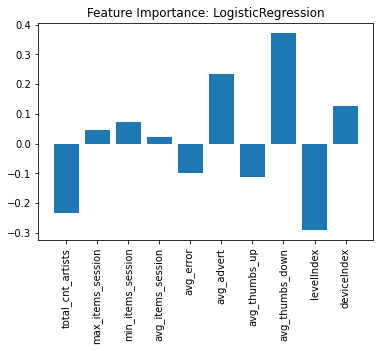

In [220]:
feature_importances(importances, "LogisticRegression")

### RandomForestClassifier

In [221]:
importances_rf = prediction_rf.bestModel.stages[0].featureImportances

In [222]:
importances_rf = [x for x in importances_rf]

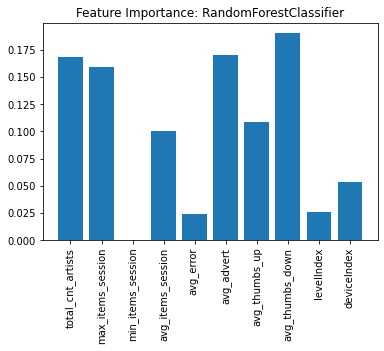

In [223]:
feature_importances(importances_rf, "RandomForestClassifier")

### Gradient-boosted Tree 

In [224]:
importances_gbt = predcition_gbt.bestModel.stages[0].featureImportances

In [225]:
importances_gbt = [x for x in importances_gbt]

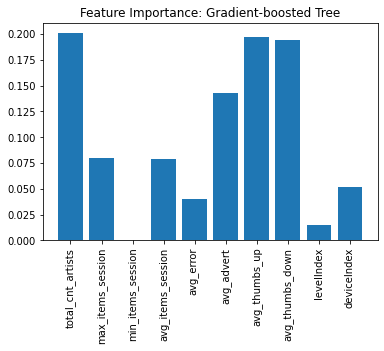

In [226]:
feature_importances(importances_gbt, "Gradient-boosted Tree")